### Set up
Download all neccessary Libraries

In [2]:
# Imports
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import cv2
import numpy as np
import sys
from segment_anything import sam_model_registry, SamPredictor
import os
import torch
from tqdm import tqdm
from pathlib import Path
from collections import deque
import json
import imageio
from IPython.display import display, HTML, Image
import base64
import re
import json

### Class Definition


Configurate all paths and parameters (setup class)
-- devices 
-- SAM model path 
-- Parameters 
-- outputs paths

In [3]:
class Config:
    # Device settings
    DEVICE = 'cuda:1' if torch.cuda.is_available() and torch.cuda.device_count() > 0 else 'cpu'

    # Model paths
    SAM_MODEL_TYPE = 'vit_h'
    SAM_CHECKPOINT = '/home/kassandralea.briola/Project/segment-anything/segment-anything/sam_vit_h_4b8939.pth'


    # Selection and tracking parameters
    MANUAL_SAMPLE_INTERVAL = 10  # Sample every Nth frame for manual selection
    MIN_TRACK_LENGTH = 5         # Minimum frames an object should be tracked
    MIN_BOX_AREA = 50            # Minimum area for valid bounding box (pixels)
    MAX_BOX_AREA = 100000        # Maximum area for valid bounding box (pixels)
    MIN_BOX_RATIO = 0.01         # Minimum width/height ratio for valid boxes
    MAX_BOX_RATIO = 10.0         # Maximum width/height ratio for valid boxes
    GRID_STEP = 50               # Pixel interval for coordinate grid

    @staticmethod
    def setup_paths(output_base_dir):
        Config.OUTPUT_BASE_DIR = output_base_dir
        Config.verify_paths()

    # Directory for outputs
    @staticmethod
    def get_video_dirs(video_name, create=True):
        video_dirs = {
            'base': Config.OUTPUT_BASE_DIR,
            'frames': os.path.join(Config.OUTPUT_BASE_DIR, 'frames', video_name, 'frames'),
            'masks': os.path.join(Config.OUTPUT_BASE_DIR, 'masks', video_name, 'masks'),
            'segmented': os.path.join(Config.OUTPUT_BASE_DIR, 'boxes', video_name, 'frames_with_boxes'),
            'segmented_only': os.path.join(Config.OUTPUT_BASE_DIR, 'segmented_only', video_name, 'frames'), 
            'videos': os.path.join(Config.OUTPUT_BASE_DIR, 'videos', video_name),
            'tracking_results': os.path.join(Config.OUTPUT_BASE_DIR, 'tracking_results', video_name),
            'selections': os.path.join(Config.OUTPUT_BASE_DIR, 'selections', video_name)
        }
        if create:
            for dir_path in video_dirs.values():
                os.makedirs(dir_path, exist_ok=True)
        return video_dirs

    @staticmethod
    def verify_paths():
        if not Config.OUTPUT_BASE_DIR:
            raise ValueError("OUTPUT_BASE_DIR not set. Call setup_paths first.")
        os.makedirs(Config.OUTPUT_BASE_DIR, exist_ok=True)

Manages user input, visual feedback, and stores the selected coordinates and boxes  
Enables interactive manual object's selection in video frames for object detection, tracking and segmentation  
interface display each frame with a coordinate grid  
user adds or remove points from currend frame
SAM model generate boundign boxes and assign IDs to object and generate sementation masks



In [4]:
class ManualCoordinateSelector:
    def __init__(self, sam_predictor=None):
        self.boxes = {}  
        self.points = {}  
        self.obj_id = 1  # Unique ID for each object
        self.selected_objects = set()  # Track selected obj_ids
        self.sam_predictor = sam_predictor
        self.last_frame_idx = None

    def _add_coordinate_grid(self, frame, frame_idx):
        grid_frame = frame.copy()
        height, width = grid_frame.shape[:2]
        step = Config.GRID_STEP
        for x in range(0, width, step):
            cv2.line(grid_frame, (x, 0), (x, height), (128, 128, 128), 1)
            cv2.putText(grid_frame, str(x), (x, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        for y in range(0, height, step):
            cv2.line(grid_frame, (0, y), (width, y), (128, 128, 128), 1)
            cv2.putText(grid_frame, str(y), (5, y+10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
        if frame_idx in self.points:
            for point in self.points[frame_idx]:
                x, y, obj_id = point
                cv2.circle(grid_frame, (int(x), int(y)), 5, (0, 255, 0), -1)
                label = f"ID:{obj_id}"
                cv2.putText(grid_frame, label, (int(x), int(y)-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        if frame_idx in self.boxes:
            for box in self.boxes[frame_idx]:
                x1, y1, x2, y2, obj_id = box
                cv2.rectangle(grid_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        return grid_frame

    def _display_frame(self, frame):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, buffer = cv2.imencode('.jpg', frame_rgb)
        img_str = base64.b64encode(buffer).decode('utf-8')
        display(Image(data=base64.b64decode(img_str)))

    def get_user_selections(self, video_path, cap, reader, total_frames):
        self.boxes = {}
        self.points = {}
        self.obj_id = 1
        self.selected_objects = set()
        self.last_frame_idx = None

        if self.sam_predictor is None:
            print("⚠️ SAM predictor not initialized. Cannot select objects.")
            return None

        frame_idx = 0
        while True:
            if cap is not None and cap.isOpened():
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if not ret or frame is None:
                    print(f"⚠️ Failed to read frame {frame_idx}")
                    return None
            elif reader is not None:
                try:
                    frame = reader.get_data(frame_idx)
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                except Exception as e:
                    print(f"⚠️ Failed to read frame {frame_idx}: {str(e)}")
                    return None
            else:
                print("⚠️ No valid video reader")
                return None

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            grid_frame = self._add_coordinate_grid(frame, frame_idx)
            print(f"\n=== Frame {frame_idx}/{total_frames-1} ===")
            print(f"Frame shape: {frame.shape} (width: {frame.shape[1]}, height: {frame.shape[0]})")
            self._display_frame(grid_frame)

            display(HTML(f"<b>Frame {frame_idx}: Select points for new objects or navigate</b>"))
            while True:
                print("\nOptions:")
                print("  a: Add a point for a new object")
                print("  r: Remove the last point added in this frame")
                print(f"  n: Move to next frame (step {Config.MANUAL_SAMPLE_INTERVAL})")
                print(f"  f: Move to a specific frame (0-{total_frames-1})")
                print("  j: Jump to a different video") 
                print("  s: Skip this video")
                print("  t: Terminate all processing")
                print("  q: Finish selection and save for this video")
                sys.stdout.flush()
                try:
                    choice = input("Enter choice (a, r, n, f, j, s, t, q): ").strip().lower()
                    print(f"User entered choice: '{choice}'")
                    sys.stdout.flush()
                except (EOFError, KeyboardInterrupt):
                    print("⚠️ Input interrupted. Please try again.")
                    continue

                if choice == 'a':
                    try:
                        coords = input("Enter x y coordinates (e.g., '230 100'): ").strip()
                        print(f"User entered coordinates: '{coords}'")
                        sys.stdout.flush()
                        parts = [p for p in re.split(r'\s+', coords.strip()) if p]
                        if len(parts) != 2:
                            print("⚠️ Invalid input. Enter exactly two numbers separated by a space (e.g., '230 100').")
                            continue
                        try:
                            x, y = map(float, parts)
                        except ValueError:
                            print("⚠️ Invalid coordinates. Both x and y must be numbers (e.g., '230 100').")
                            continue

                        if not (0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]):
                            print(f"⚠️ Point ({x}, {y}) is outside frame boundaries (width: 0-{frame.shape[1]-1}, height: 0-{frame.shape[0]-1}).")
                            continue

                        if frame_idx != self.last_frame_idx:
                            self.sam_predictor.set_image(frame_rgb)
                            self.last_frame_idx = frame_idx
                        masks, scores, _ = self.sam_predictor.predict(
                            point_coords=np.array([[x, y]]),
                            point_labels=np.array([1]),
                            multimask_output=True
                        )
                        best_mask_idx = np.argmax(scores)
                        mask = masks[best_mask_idx]
                        coords = np.where(mask)
                        if len(coords[0]) == 0:
                            print("⚠️ No valid mask generated for this point. Try a different point.")
                            continue
                        x1, y1 = int(np.min(coords[1])), int(np.min(coords[0]))
                        x2, y2 = int(np.max(coords[1])), int(np.max(coords[0]))
                        area = (x2 - x1) * (y2 - y1)
                        ratio = (x2 - x1) / (y2 - y1) if (y2 - y1) > 0 else float('inf')
                        if not (Config.MIN_BOX_AREA <= area <= Config.MAX_BOX_AREA and
                                Config.MIN_BOX_RATIO <= ratio <= Config.MAX_BOX_RATIO):
                            print(f"⚠️ Invalid box generated: area={area}, ratio={ratio}. Try a different point.")
                            continue

                        if frame_idx not in self.points:
                            self.points[frame_idx] = []
                        if frame_idx not in self.boxes:
                            self.boxes[frame_idx] = []
                        self.points[frame_idx].append([float(x), float(y), self.obj_id])
                        self.boxes[frame_idx].append([x1, y1, x2, y2, self.obj_id])
                        print(f"✅ Added point ID:{self.obj_id} at ({x:.1f}, {y:.1f}), box: ({x1:.1f}, {y1:.1f})-({x2:.1f}, {y2:.1f})")
                        sys.stdout.flush()
                        self._display_frame(self._add_coordinate_grid(frame, frame_idx))
                        self.selected_objects.add(self.obj_id)
                        self.obj_id += 1
                    except Exception as e:
                        print(f"⚠️ Error processing point: {str(e)}. Please try again.")
                        sys.stdout.flush()
                elif choice == 'r':
                    if frame_idx in self.points and self.points[frame_idx]:
                        removed_point = self.points[frame_idx].pop()
                        self.boxes[frame_idx].pop()
                        removed_obj_id = removed_point[2]
                        self.selected_objects.discard(removed_obj_id)
                        self.obj_id = max(self.selected_objects, default=0) + 1
                        if not self.points[frame_idx]:
                            del self.points[frame_idx]
                            del self.boxes[frame_idx]
                        print(f"✅ Removed point ID:{removed_obj_id}")
                        self._display_frame(self._add_coordinate_grid(frame, frame_idx))
                    else:
                        print("⚠️ No points to remove in this frame.")
                    sys.stdout.flush()
                elif choice == 'n':
                    frame_idx = min(frame_idx + Config.MANUAL_SAMPLE_INTERVAL, total_frames - 1)
                    print(f"Moving to frame {frame_idx}")
                    sys.stdout.flush()
                    break
                elif choice == 'f':
                    try:
                        new_idx = input(f"Enter frame number (0-{total_frames-1}): ").strip()
                        print(f"User entered frame: '{new_idx}'")
                        sys.stdout.flush()
                        new_idx = int(new_idx)
                        if 0 <= new_idx < total_frames:
                            frame_idx = new_idx
                            print(f"Moving to frame {frame_idx}")
                            sys.stdout.flush()
                            break
                        else:
                            print(f"⚠️ Frame number out of range. Enter an integer between 0 and {total_frames-1}.")
                            sys.stdout.flush()
                    except ValueError:
                        print("⚠️ Invalid input. Frame number must be an integer.")
                        sys.stdout.flush()
                # In get_user_selections():
                elif choice == 'j':  # Jump to video option
                    print(f"\nCurrent video: {os.path.splitext(os.path.basename(video_path))[0]}")
                    return {'action': 'jump'}
                elif choice == 's':
                    print(f"✅ Skipping video {os.path.basename(video_path)}")
                    sys.stdout.flush()
                    return {'action': 'skip'}
                elif choice == 't':
                    print("✅ Terminating all processing as requested by user.")
                    sys.stdout.flush()
                    raise SystemExit("Terminated by user request")
                elif choice == 'q':
                    if not self.boxes:
                        print("⚠️ No selections made. Select at least one point before exiting, or use 's' to skip.")
                        sys.stdout.flush()
                        continue
                    print("✅ Saving selections and exiting selection phase.")
                    sys.stdout.flush()
                    return self.boxes
                else:
                    print(f"⚠️ Invalid choice '{choice}'. Please enter 'a', 'r', 'n', 'f', 's', 't', 'j' or 'q'.")
                    sys.stdout.flush()

Initializes SAM (Segment-anything) model 


In [5]:
class ModelManager:
    def __init__(self, sam_checkpoint=Config.SAM_CHECKPOINT, sam_model_type=Config.SAM_MODEL_TYPE, device=Config.DEVICE):
        self.sam = None
        self.device = device
        self.load_sam(sam_checkpoint, sam_model_type)

    def load_sam(self, checkpoint_path, model_type):
        print(f"Loading SAM model: type={model_type}, checkpoint={checkpoint_path}, device={self.device}")
        try:
            if checkpoint_path is None or not os.path.exists(checkpoint_path):
                raise FileNotFoundError(f"SAM checkpoint not found at {checkpoint_path}")
            if not torch.cuda.is_available() and self.device.startswith('cuda'):
                print("⚠️ CUDA not available, falling back to CPU")
                self.device = 'cpu'
            sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
            sam.to(device=self.device)
            self.sam = SamPredictor(sam)
            print(f"✅ SAM model ({model_type}) loaded on {self.device}")
        except Exception as e:
            print(f"⚠️ Failed to load SAM: {str(e)}")
            self.sam = None

Track invidual object and store its ID,bouding boxe, confidence score and last known position


In [10]:
class TrackWrapper:
    def __init__(self, obj_id, bbox, conf, last_position=None):
        self.obj_id = obj_id
        self.bbox = bbox  # [x1, y1, x2, y2]
        self.conf = conf
        self.last_position = last_position  # (cx, cy) for occlusion handling

    def update(self, bbox, conf, last_position=None):
        self.bbox = bbox
        self.conf = conf
        self.last_position = last_position

Video processing  
-extract frames  
-handle manual selection  
-track object accross frames  
-apply segmentation  
-visualize results  
-save output

In [7]:
class VideoProcessor:
    def __init__(self, video_dirs, model_manager, current_video):
        self.video_dirs = video_dirs
        self.model_manager = model_manager
        self.current_video = current_video
        self.selections = {}
        self.manual_tracks = {}
        self.track_history = {}
        self.color_map = {}

    def _get_color(self, obj_id):
        if obj_id not in self.color_map:
            self.color_map[obj_id] = tuple(np.random.randint(0, 255, 3).tolist())
        return self.color_map[obj_id]
    
    def enhance_segmentation(self, frame, mask, bbox):
            """Enhance the segmentation mask and refine the bounding box."""
            import cv2
            import numpy as np
            # Morphological smoothing
            kernel = np.ones((3,3), np.uint8)
            mask = cv2.dilate(mask, kernel, iterations=1)
            mask = cv2.erode(mask, kernel, iterations=1)
            
            # Refine bbox based on updated mask
            coords = np.where(mask)
            if len(coords[0]) > 0:
                x1, y1 = int(np.min(coords[1])), int(np.min(coords[0]))
                x2, y2 = int(np.max(coords[1])), int(np.max(coords[0]))
                return [x1, y1, x2, y2], mask
            return bbox, mask

    def _visualize_results(self, frame, tracks, masks):
        """Original frame with segmentation overlay and bounding boxes"""
        vis_frame = frame.copy()  # Keep original frame intact
        for track, mask in zip(tracks, masks):
            if mask is not None:
                color = self._get_color(track.obj_id)
                # Create transparent overlay
                overlay = np.zeros_like(frame)
                overlay[mask == 1] = color
                vis_frame = cv2.addWeighted(overlay, 0.5, vis_frame, 1.0, 0)
                
                # Draw bounding box
                x1, y1, x2, y2 = map(int, track.bbox)
                cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)
                label = f"ID:{track.obj_id} ({track.conf:.2f})"
                cv2.putText(vis_frame, label, (x1, y1-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        return vis_frame

    def _visualize_segmented_only(self, frame, tracks, masks):
        """Original frame with only segmentation overlay (no boxes/labels)"""
        vis_frame = frame.copy()  # Keep original frame intact
        for track, mask in zip(tracks, masks):
            if mask is not None:
                color = self._get_color(track.obj_id)
                # Create transparent overlay
                overlay = np.zeros_like(frame)
                overlay[mask == 1] = color
                vis_frame = cv2.addWeighted(overlay, 0.5, vis_frame, 1.0, 0)
        return vis_frame

    def extract_frames(self, video_path):
        os.makedirs(self.video_dirs['frames'], exist_ok=True)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"⚠️ Failed to open video {video_path}")
            return
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(self.video_dirs['frames'], f"frame_{frame_idx:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_idx += 1
        cap.release()
        print(f"Extracted {frame_idx} frames to {self.video_dirs['frames']}")

    def reconstruct_video(self, frame_dir, output_path, fps):
        frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith(('.jpg', '.png'))])
        if not frame_files:
            print(f"No frames found in {frame_dir}")
            return
        
        # Get frame dimensions from first frame
        first_frame = cv2.imread(os.path.join(frame_dir, frame_files[0]))
        if first_frame is None:
            print("Failed to read first frame")
            return
        height, width = first_frame.shape[:2]
        
        # WEBM writer configuration
        fourcc = cv2.VideoWriter_fourcc(*'VP80')  # VP8 codec for WEBM
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        if not out.isOpened():
            print("Failed to create video writer")
            return
        
        for frame_file in tqdm(frame_files, desc="Reconstructing video"):
            frame_path = os.path.join(frame_dir, frame_file)
            frame = cv2.imread(frame_path)
            if frame is None:
                continue
                
            # Write original frame (with any overlays already applied during visualization)
            out.write(frame)
        
        out.release()
        print(f"Video saved to {output_path}")

    def manual_selection_phase(self, video_path):
        print("\n=== PHASE 1: Manual Object Selection ===")
        if self.model_manager.sam is None:
            print(" SAM predictor not initialized. Cannot proceed with manual selection.")
            return None

        cap = cv2.VideoCapture(video_path)
        reader = None
        if not cap.isOpened():
            try:
                reader = imageio.get_reader(video_path)
                print("Using imageio fallback reader")
            except Exception as e:
                print(f" Imageio fallback failed: {str(e)}")
                return None

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap.isOpened() else len(reader)
        selector = ManualCoordinateSelector(self.model_manager.sam)
        selection_result = selector.get_user_selections(video_path, cap, reader, total_frames)

        if cap.isOpened():
            cap.release()
        if reader is not None:
            reader.close()

        # Handle special actions (jump/skip)
        if isinstance(selection_result, dict) and 'action' in selection_result:
            return selection_result

        if not selection_result:
            print(" No selections made")
            return None

        # Only process selections if we got actual boxes
        self.selections = {int(k): v for k, v in selection_result.items()}
        for frame_idx, boxes in self.selections.items():
            for box in boxes:
                x1, y1, x2, y2, obj_id = box
                self.manual_tracks[obj_id] = {
                    'first_frame': int(frame_idx),
                    'first_box': [x1, y1, x2, y2],
                    'first_point': None
                }
                if frame_idx in selector.points:
                    for point in selector.points[frame_idx]:
                        if point[2] == obj_id:
                            self.manual_tracks[obj_id]['first_point'] = point[:2]
                            break

        os.makedirs(self.video_dirs['selections'], exist_ok=True)
        output_file = os.path.join(self.video_dirs['selections'], 'manual_selections.json')
        with open(output_file, 'w') as f:
            json.dump(self.selections, f)
        print(f" Saved manual selections to {output_file}")
        return output_file

    def tracking_and_segmentation_phase(self, video_path):
        print("\n=== PHASE 2: Tracking and Segmentation ===")
        if self.model_manager.sam is None:
            print("⚠️ SAM not available - skipping")
            return None

        if not os.path.exists(self.video_dirs['frames']) or not os.listdir(self.video_dirs['frames']):
            print("Extracting frames...")
            self.extract_frames(video_path)

        frame_files = sorted([f for f in os.listdir(self.video_dirs['frames']) if f.endswith(('.jpg', '.png'))])
        mask_metadata = {}
        frame_shape = cv2.imread(os.path.join(self.video_dirs['frames'], frame_files[0])).shape[:2]

        # Create a new directory for segmented-only frames
        segmented_only_dir = os.path.join(self.video_dirs['base'], 'segmented_only', self.current_video, 'frames')
        os.makedirs(segmented_only_dir, exist_ok=True)

        for obj_id in self.manual_tracks:
            self.track_history[obj_id] = {
                'positions': deque(maxlen=Config.MIN_TRACK_LENGTH*2),
                'frame_count': 0,
                'frames': {},
                'last_mask': None,
                'last_box': self.manual_tracks[obj_id]['first_box'],
                'occlusion_count': 0,
                'max_occlusion': 5,
                'velocity': None
            }

        start_idx = min(self.manual_tracks[obj_id]['first_frame'] for obj_id in self.manual_tracks)
        obj_ids = list(self.manual_tracks.keys())

        for frame_idx in tqdm(range(start_idx, len(frame_files)), desc="Processing frames"):
            frame_file = frame_files[frame_idx]
            frame_path = os.path.join(self.video_dirs['frames'], frame_file)
            frame = cv2.imread(frame_path)
            if frame is None:
                continue
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            self.model_manager.sam.set_image(frame_rgb)

            if frame_idx not in mask_metadata:
                mask_metadata[frame_idx] = []
            tracks = []
            masks = []

            for obj_id in obj_ids:
                history = self.track_history[obj_id]
                if history['occlusion_count'] > history['max_occlusion']:
                    masks.append(None)
                    continue

                try:
                    use_point = False
                    prompt = None
                    if frame_idx == self.manual_tracks[obj_id]['first_frame']:
                        x1, y1, x2, y2 = self.manual_tracks[obj_id]['first_box']
                        point = self.manual_tracks[obj_id]['first_point']
                        if point is not None:
                            prompt = np.array([point])
                            use_point = True
                        else:
                            prompt = np.array([[x1, y1, x2, y2]])
                    else:
                        last_box = history['last_box']
                        if last_box is not None:
                            x1, y1, x2, y2 = last_box
                            cx = (x1 + x2) / 2
                            cy = (y1 + y2) / 2
                            if history['velocity'] is not None and history['occlusion_count'] > 0:
                                vx, vy = history['velocity']
                                cx += vx * history['occlusion_count']
                                cy += vy * history['occlusion_count']
                                w = x2 - x1
                                h = y2 - y1
                                x1 = cx - w / 2
                                x2 = cx + w / 2
                                y1 = cy - h / 2
                                y2 = cy + h / 2
                                x1 = max(0, min(x1, frame_shape[1] - 1))
                                x2 = max(0, min(x2, frame_shape[1] - 1))
                                y1 = max(0, min(y1, frame_shape[0] - 1))
                                y2 = max(0, min(y2, frame_shape[0] - 1))
                            if x1 >= x2 or y1 >= y2:
                                history['occlusion_count'] += 1
                                masks.append(None)
                                continue
                            prompt = np.array([[x1, y1, x2, y2]])
                        elif history['last_mask'] is not None:
                            coords = np.where(history['last_mask'])
                            if len(coords[0]) > 0:
                                x1, y1 = int(np.min(coords[1])), int(np.min(coords[0]))
                                x2, y2 = int(np.max(coords[1])), int(np.max(coords[0]))
                                if x1 >= x2 or y1 >= y2:
                                    history['occlusion_count'] += 1
                                    masks.append(None)
                                    continue
                                prompt = np.array([[x1, y1, x2, y2]])
                                history['last_box'] = [x1, y1, x2, y2]

                    if prompt is None:
                        history['occlusion_count'] += 1
                        masks.append(None)
                        continue

                    try:
                        if use_point:
                            sam_masks, scores, _ = self.model_manager.sam.predict(
                                point_coords=prompt,
                                point_labels=np.array([1]),
                                multimask_output=True
                            )
                        else:
                            sam_masks, scores, _ = self.model_manager.sam.predict(
                                box=prompt,
                                multimask_output=True
                            )
                        best_mask_idx = np.argmax(scores)
                        mask = sam_masks[best_mask_idx].astype(np.uint8)
                        conf = float(scores[best_mask_idx])
                    except Exception:
                        history['occlusion_count'] += 1
                        masks.append(None)
                        continue

                    coords = np.where(mask)
                    if len(coords[0]) == 0:
                        history['occlusion_count'] += 1
                        masks.append(None)
                        continue

                    # Enhance the segmentation
                    bbox, mask = self.enhance_segmentation(frame, mask, [x1, y1, x2, y2])
                    coords = np.where(mask)
                    if len(coords[0]) > 0:
                        x1, y1 = int(np.min(coords[1])), int(np.min(coords[0]))
                        x2, y2 = int(np.max(coords[1])), int(np.max(coords[0]))
                        bbox = [x1, y1, x2, y2]

                    history['occlusion_count'] = 0
                    cx = (x1 + x2) / 2
                    cy = (y1 + y2) / 2

                    if len(history['positions']) >= 2:
                        prev_cx, prev_cy = history['positions'][-1]
                        vx = cx - prev_cx
                        vy = cy - prev_cy
                        history['velocity'] = (vx, vy)
                    history['positions'].append((cx, cy))

                    history['frame_count'] += 1
                    history['frames'][frame_idx] = {
                        'bbox': bbox,
                        'conf': conf
                    }
                    history['last_mask'] = mask
                    history['last_box'] = bbox

                    mask_path = os.path.join(self.video_dirs['masks'], f"frame_{frame_idx:04d}_track_{obj_id}.npy")
                    np.save(mask_path, mask)
                    mask_metadata[frame_idx].append({
                        'track_id': obj_id,
                        'bbox': bbox,
                        'mask_file': f"frame_{frame_idx:04d}_track_{obj_id}.npy",
                        'score': conf
                    })

                    try:
                        track = TrackWrapper(obj_id, bbox, conf, last_position=(cx, cy))
                        tracks.append(track)
                        masks.append(mask)
                    except Exception:
                        masks.append(None)
                        continue

                except Exception:
                    history['occlusion_count'] += 1
                    masks.append(None)
                    continue

            # Save original frames with boxes and IDs
            if tracks:
                overlay_frame = self._visualize_results(frame, tracks, masks)
                seg_path = os.path.join(self.video_dirs['segmented'], f"frame_{frame_idx:04d}.jpg")
                cv2.imwrite(seg_path, overlay_frame)
                
                # Save new frames with only segmented objects
                segmented_only_frame = self._visualize_segmented_only(frame, tracks, masks)
                seg_only_path = os.path.join(segmented_only_dir, f"frame_{frame_idx:04d}.jpg")
                cv2.imwrite(seg_only_path, segmented_only_frame)
            else:
                seg_path = os.path.join(self.video_dirs['segmented'], f"frame_{frame_idx:04d}.jpg")
                cv2.imwrite(seg_path, frame)
                seg_only_path = os.path.join(segmented_only_dir, f"frame_{frame_idx:04d}.jpg")
                cv2.imwrite(seg_only_path, frame)

        valid_tracks = {k: v for k, v in self.track_history.items() if v['frame_count'] >= Config.MIN_TRACK_LENGTH}
        self.track_history = valid_tracks

        tracking_file = os.path.join(self.video_dirs['tracking_results'], 'tracking_results.json')
        with open(tracking_file, 'w') as f:
            serializable = {
                track_id: {
                    'positions': list(history['positions']),
                    'frame_count': history['frame_count'],
                    'frames': {int(k): v for k, v in history['frames'].items()}
                } for track_id, history in self.track_history.items()
            }
            json.dump(serializable, f)

        # Reconstruct original video with boxes
        output_path = os.path.join(self.video_dirs['videos'], f"{self.current_video}_segmented.webm")
        self.reconstruct_video(self.video_dirs['segmented'], output_path, 30)

        # Reconstruct new video with only segmented objects
        output_segmented_only_path = os.path.join(self.video_dirs['videos'], f"{self.current_video}_segmented_only.webm")
        self.reconstruct_video(segmented_only_dir, output_segmented_only_path, 30)

        metadata_file = os.path.join(self.video_dirs['masks'], 'mask_metadata.json')
        with open(metadata_file, 'w') as f:
            json.dump(mask_metadata, f)

        print(f"✅ Segmented video with boxes saved to {output_path}")
        print(f"✅ Segmented-only video saved to {output_segmented_only_path}")
        print(f"✅ Tracking results saved to {tracking_file}")
        print(f"✅ Mask metadata saved to {metadata_file}")
        return output_segmented_only_path

### MAIN EXECUTION


clear cuda cache to save memory

In [8]:
torch.cuda.empty_cache()

##### Main function / Custom interface / Run the code
-loads paths  
-loads model  
-iterate through video files  
-manual selection / tracking / segmentation  
  
-add/remove points  
-jump to/skip videos  
-naviguate through frames  
-save output  


Loading SAM model: type=vit_h, checkpoint=/home/kassandralea.briola/Project/segment-anything/segment-anything/sam_vit_h_4b8939.pth, device=cuda:1
✅ SAM model (vit_h) loaded on cuda:1

Processing video: 1 (Ground Truth Label: putting a paint tube, Template: Putting [something similar to other things that are already on the table])

=== PHASE 1: Manual Object Selection ===

=== Frame 0/46 ===
Frame shape: (240, 427, 3) (width: 427, height: 240)


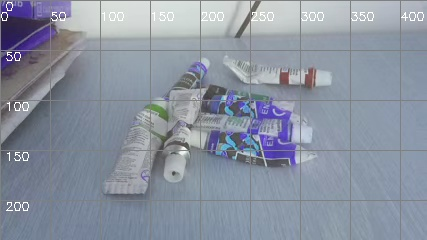


Options:
  a: Add a point for a new object
  r: Remove the last point added in this frame
  n: Move to next frame (step 10)
  f: Move to a specific frame (0-46)
  j: Jump to a different video
  s: Skip this video
  t: Terminate all processing
  q: Finish selection and save for this video
User entered choice: 'j'

Current video: 1
Jumping to video: 172868.webm (Ground Truth Label: opening laptop, Template: Opening [something])

Processing video: 172868 (Ground Truth Label: opening laptop, Template: Opening [something])

=== PHASE 1: Manual Object Selection ===

=== Frame 0/60 ===
Frame shape: (240, 427, 3) (width: 427, height: 240)


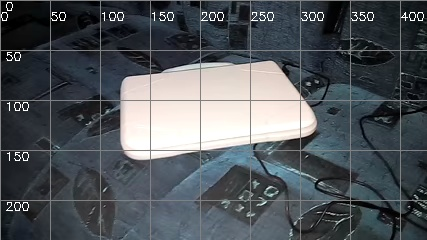


Options:
  a: Add a point for a new object
  r: Remove the last point added in this frame
  n: Move to next frame (step 10)
  f: Move to a specific frame (0-60)
  j: Jump to a different video
  s: Skip this video
  t: Terminate all processing
  q: Finish selection and save for this video
User entered choice: 'a'
User entered coordinates: '200 100'
✅ Added point ID:1 at (200.0, 100.0), box: (120.0, 61.0)-(316.0, 159.0)


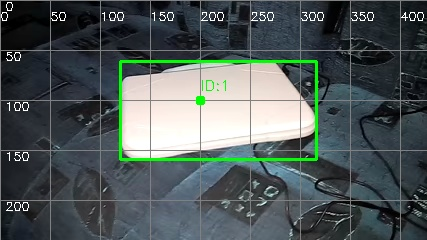


Options:
  a: Add a point for a new object
  r: Remove the last point added in this frame
  n: Move to next frame (step 10)
  f: Move to a specific frame (0-60)
  j: Jump to a different video
  s: Skip this video
  t: Terminate all processing
  q: Finish selection and save for this video
User entered choice: 'n'
Moving to frame 10

=== Frame 10/60 ===
Frame shape: (240, 427, 3) (width: 427, height: 240)


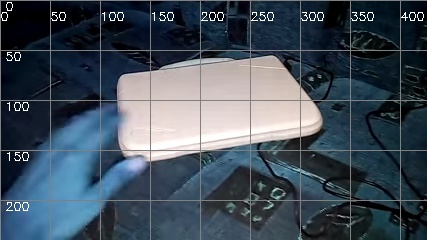


Options:
  a: Add a point for a new object
  r: Remove the last point added in this frame
  n: Move to next frame (step 10)
  f: Move to a specific frame (0-60)
  j: Jump to a different video
  s: Skip this video
  t: Terminate all processing
  q: Finish selection and save for this video
User entered choice: 'a'
User entered coordinates: '50 150'
✅ Added point ID:2 at (50.0, 150.0), box: (0.0, 105.0)-(146.0, 238.0)


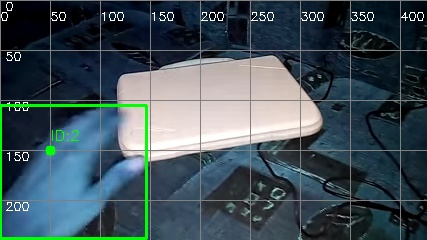


Options:
  a: Add a point for a new object
  r: Remove the last point added in this frame
  n: Move to next frame (step 10)
  f: Move to a specific frame (0-60)
  j: Jump to a different video
  s: Skip this video
  t: Terminate all processing
  q: Finish selection and save for this video
User entered choice: 'q'
✅ Saving selections and exiting selection phase.
 Saved manual selections to /home/kassandralea.briola/Project/output/selections/172868/manual_selections.json

=== PHASE 2: Tracking and Segmentation ===
Extracting frames...
Extracted 61 frames to /home/kassandralea.briola/Project/output/frames/172868/frames


Processing frames: 100%|██████████| 61/61 [00:27<00:00,  2.19it/s]
OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'
Reconstructing video: 100%|██████████| 61/61 [00:03<00:00, 15.50it/s]
OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


Video saved to /home/kassandralea.briola/Project/output/videos/172868/172868_segmented.webm


Reconstructing video: 100%|██████████| 61/61 [00:03<00:00, 16.09it/s]


Video saved to /home/kassandralea.briola/Project/output/videos/172868/172868_segmented_only.webm
✅ Segmented video with boxes saved to /home/kassandralea.briola/Project/output/videos/172868/172868_segmented.webm
✅ Segmented-only video saved to /home/kassandralea.briola/Project/output/videos/172868/172868_segmented_only.webm
✅ Tracking results saved to /home/kassandralea.briola/Project/output/tracking_results/172868/tracking_results.json
✅ Mask metadata saved to /home/kassandralea.briola/Project/output/masks/172868/masks/mask_metadata.json
Completed processing 172868: /home/kassandralea.briola/Project/output/videos/172868/172868_segmented_only.webm

Processing video: 172869 (Ground Truth Label: throwing cd cover against bed, Template: Throwing [something] against [something])

=== PHASE 1: Manual Object Selection ===

=== Frame 0/33 ===
Frame shape: (240, 427, 3) (width: 427, height: 240)


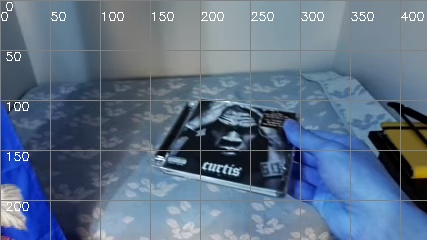


Options:
  a: Add a point for a new object
  r: Remove the last point added in this frame
  n: Move to next frame (step 10)
  f: Move to a specific frame (0-33)
  j: Jump to a different video
  s: Skip this video
  t: Terminate all processing
  q: Finish selection and save for this video
User entered choice: 'j'

Current video: 172869
Video 't' not found. Available videos:
  - 1 (Label: putting a paint tube, Template: Putting [something similar to other things that are already on the table])
  - 10 (Label: covering glass with handkerchief, Template: Covering [something] with [something])
  - 100 (Label: putting a knife and another knife on the table, Template: Putting [something] and [something] on the table)
  - 1000 (Label: Unknown, Template: Unknown)
  - 10000 (Label: letting green brinjal roll along a flat surface, Template: Letting [something] roll along a flat surface)
  - 100000 (Label: dropping scissors behind trash can, Template: Dropping [something] behind [something])
  - 1

KeyboardInterrupt: 

In [11]:
def process_videos(video_dir, output_base_dir):
    # Load label files for ground truth
    label_files = {
        'train': '/home/kassandralea.briola/Project/datasets/something_something_v2/labels/train.json',
        'validation': '/home/kassandralea.briola/Project/datasets/something_something_v2/labels/validation.json'
    }
    
    # Map video IDs to ground truth labels and templates
    video_label_map = {}  # Maps video_id to {'label': str, 'template': str}
    for split in ['train', 'validation']:
        try:
            with open(label_files[split], 'r') as f:
                data = json.load(f)
                for item in data:
                    video_id = str(item['id'])
                    video_label_map[video_id] = {
                        'label': item.get('label', 'Unknown'),
                        'template': item.get('template', 'Unknown')
                    }
        except Exception as e:
            print(f"⚠️ Failed to load {split}.json: {str(e)}")

    Config.setup_paths(output_base_dir)
    Config.verify_paths()
    model_manager = ModelManager(sam_checkpoint=Config.SAM_CHECKPOINT, sam_model_type=Config.SAM_MODEL_TYPE)
    if model_manager.sam is None:
        print("Failed to initialize SAM. Exiting.")
        return

    video_files = sorted([f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.webm', '.avi'))])
    current_video_index = 0

    while current_video_index < len(video_files):
        video_file = video_files[current_video_index]
        video_name = os.path.splitext(video_file)[0]
        video_path = os.path.join(video_dir, video_file)
        
        # Get ground truth label and template
        label_info = video_label_map.get(video_name, {'label': 'Unknown', 'template': 'Unknown'})
        ground_truth_label = label_info['label']
        template = label_info['template']
        print(f"\nProcessing video: {video_name} (Ground Truth Label: {ground_truth_label}, Template: {template})")

        video_dirs = Config.get_video_dirs(video_name, create=False)
        processor = VideoProcessor(video_dirs, model_manager, video_name)

        selection_result = processor.manual_selection_phase(video_path)
        
        # Handle jump action
        if isinstance(selection_result, dict) and selection_result.get('action') == 'jump':
            video_to_jump = input("Enter exact video name to jump to (without extension): ").strip()
            matching_videos = [i for i, v in enumerate(video_files) 
                              if os.path.splitext(v)[0] == video_to_jump]
            if matching_videos:
                current_video_index = matching_videos[0]
                # Print ground truth for the jumped-to video
                video_name = os.path.splitext(video_files[current_video_index])[0]
                label_info = video_label_map.get(video_name, {'label': 'Unknown', 'template': 'Unknown'})
                ground_truth_label = label_info['label']
                template = label_info['template']
                print(f"Jumping to video: {video_files[current_video_index]} (Ground Truth Label: {ground_truth_label}, Template: {template})")
                continue
            else:
                print(f"Video '{video_to_jump}' not found. Available videos:")
                for v in video_files:
                    v_name = os.path.splitext(v)[0]
                    v_label_info = video_label_map.get(v_name, {'label': 'Unknown', 'template': 'Unknown'})
                    print(f"  - {v_name} (Label: {v_label_info['label']}, Template: {v_label_info['template']})")
                continue
            
        # Handle skip action or no selections
        if selection_result is None or (isinstance(selection_result, dict) and selection_result.get('action') == 'skip'):
            current_video_index += 1
            continue
            
        # Normal processing case
        for dir_path in video_dirs.values():
            os.makedirs(dir_path, exist_ok=True)
        output_video = processor.tracking_and_segmentation_phase(video_path)
        if output_video:
            print(f"Completed processing {video_name}: {output_video}")
        current_video_index += 1
    
if __name__ == "__main__":
    video_dir = "/home/kassandralea.briola/Project/datasets/something_something_v2/videos"
    output_base_dir = "/home/kassandralea.briola/Project/output"
    process_videos(video_dir, output_base_dir)